# Calculating swap fee based on fixed point volatility
We are referencing the fee calculation from this demo: https://github.com/jpw993/ethlondon_dynamicfeehook/blob/e4d75517e2cc3e0e4f474a14d4132d31e8c745c7/datascience/Fees.ipynb

The primary difference between our calculation and there's is that we are using fixed-point numbers, and so we have to be mindful of scale factors.


In [118]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [456]:
NUM_FRAC_BITS = 40 # Number of fractional bit for our fixed point numbers
MIN_FEE = 3.5 # A minimum fee of 3.5 USD taken from reference
MIN_FEE_FIXED = int(MIN_FEE * 2**NUM_FRAC_BITS) # The fixed point representation of this number
print("MIN_FEE_FIXED: {}".format(MIN_FEE_FIXED))

LONG_ETH_VOL = 0.6 # Long term ETH volatility, taken from reference
LONG_ETH_VOL_FIXED = int(LONG_ETH_VOL * 2**NUM_FRAC_BITS)
print("LONG_ETH_VOL: {}".format(LONG_ETH_VOL_FIXED))

ETH_VOL_SCALE = 150 # Volume scale factor, taken from source
ETH_VOL_SCALE_FIXED = int(ETH_VOL_SCALE * 2**NUM_FRAC_BITS)
print("LONG_ETH_VOL: {}".format(LONG_ETH_VOL_FIXED))

X96_FRAC_BITS = 96
ETH_PRICE = 3700 # Pick an USD/ETH price
ETH_PRICE_FIXED = ETH_PRICE << X96_FRAC_BITS

FUDGE_FACTOR = 2 # A constant from reference

# This assumes that both left and right are fixed point numbers, i.e. left = l * SCALE_FACTOR, right ...
# Result should also be a fixed point number, i.e. result = l * r * SCALE_FACTOR
# When we multiply left and right, we have an extra factor of SCALE_FACTOR, left * right = l * SCALE_FACTOR * r * SCALE_FACTOR
# So we reduce by SCALE_FACTOR
def fixed_point_mul(left, right): 
    result = left * right >> NUM_FRAC_BITS
    return result


# This assumes that both num and den are also fixed point numbers, i.e. num = n * SCALE_FACTOR, den = d * SCALE_FACTOR
# Result should be a fixed point number i.e. result = n/d * SCALE_FACTOR
# So we multiply num by SCALE_FACTOR before dividing, 
# num * SCALE_FACTOR / den  = ((n * SCALE_FACTOR) * SCALE_FACTOR)/(d * SCALE_FACTOR) = n/d * SCALE_FACTOR 
def fixed_point_divide(num, den):
    result = (num << NUM_FRAC_BITS) // den
    return result

# Fee calculation taken from reference
def calculateFee(volume, volatility):
    scaled_volume = fixed_point_divide(volume, ETH_VOL_SCALE)
    scaled_vol = fixed_point_divide(volatility, LONG_ETH_VOL_FIXED)
    scaled_vol2 = fixed_point_mul(scaled_vol, scaled_vol)
    constant_factor = FUDGE_FACTOR
    
    fee_per_lot = MIN_FEE_FIXED + constant_factor * fixed_point_mul(scaled_volume, scaled_vol2)

    return fee_per_lot 
    # return int(fee_per_lot / price / 1e10)

def calculateFeeBips(volume, volatility, price): 
    fee_per_lot = calculateFee(volume, volatility)
    
    # The price we use is fixed-point with 96 fractional bits and fee_per_lot has 40 fractional bits.
    # So if we want fee_scaled with 96 fractional bits we have to shift by 56 + 96 = 152 bits before dividing
    num_shift_bits = 2*X96_FRAC_BITS - NUM_FRAC_BITS
    fee_percent_fixed = (fee_per_lot << num_shift_bits) // price # fee_percent_scaled is fixed point with 96 fractional bits.
    
    # fee_percent_fixed is 96-bit fixed point number, i.e. fee_percent_fixed = fee_percent * SCALE_FACTOR
    # We want to represent the fee percentage in BIPs. 10_000 bip = 100% = 1. 
    # So to go from fixed-point to bips we need to multiply our fixed-point number by 10_000/SCALE_FACTOR
    fee_percent_bips = (10000 * fee_percent_fixed) >> X96_FRAC_BITS
    
    return fee_percent_bips


MIN_FEE_FIXED: 3848290697216
LONG_ETH_VOL: 659706976665
LONG_ETH_VOL: 659706976665


Text(0.5, 1.0, 'Fee for Swaps at 60% Volatility')

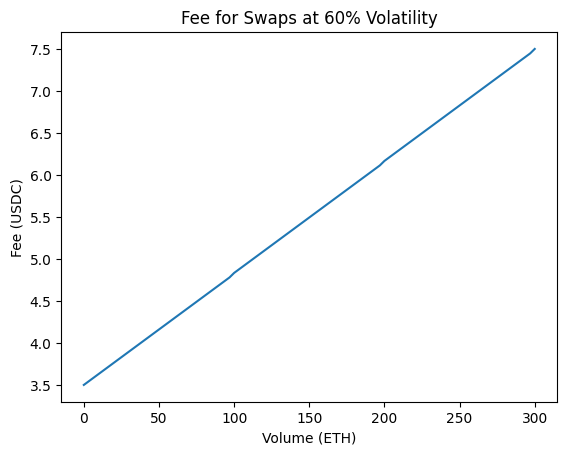

In [458]:
volatility = 0.6
volatility_fixed = int(volatility * (2**NUM_FRAC_BITS))
volume = np.linspace(0, 300, 100)

fees = [calculateFee(int(v), volatility_fixed) * 2**-NUM_FRAC_BITS for v in volume]

plt.plot(volume, fees)

# Add labels and title
plt.xlabel('Volume (ETH)')
plt.ylabel('Fee (USDC)')
plt.title('Fee for Swaps at 60% Volatility')

Text(0.5, 1.0, 'Fee for Swaps at 60% Volatility  @ 3700 $/ETH')

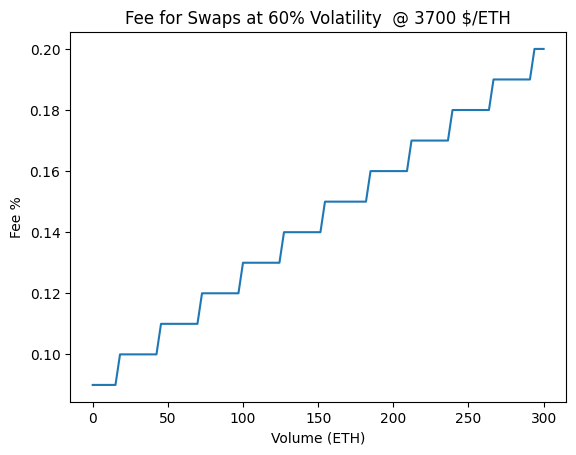

In [416]:
volatility = 0.6
volatility_fixed = int(volatility * (2**NUM_FRAC_BITS))
volume = np.linspace(0, 300, 100)

fees = [calculateFeeBips(int(v), volatility_fixed, ETH_PRICE_FIXED)/100 for v in volume]

plt.plot(volume, fees)

# Add labels and title
plt.xlabel('Volume (ETH)')
plt.ylabel('Fee %')
plt.title('Fee for Swaps at 60% Volatility  @ {} $/ETH'.format(ETH_PRICE))

Text(0.5, 1.0, 'Fee for 150ETH Swap')

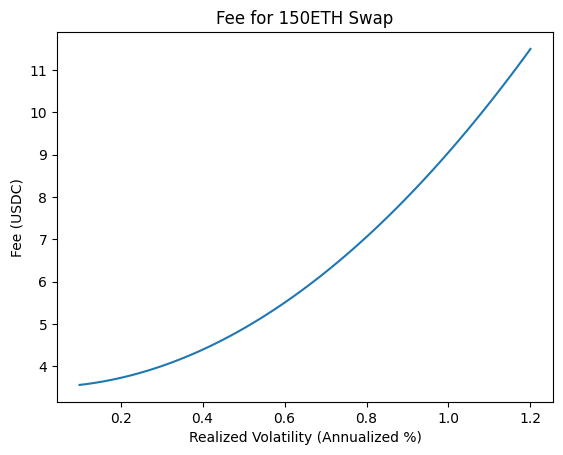

In [407]:
volatility = np.linspace(0.1, 1.2, 100)
volume = 150
fees = [calculateFee(volume, int(v * 2**NUM_FRAC_BITS)) * 2**-NUM_FRAC_BITS for v in volatility]
plt.plot(volatility, fees)

# Add labels and title
plt.xlabel('Realized Volatility (Annualized %)')
plt.ylabel('Fee (USDC)')
plt.title('Fee for 150ETH Swap')


Text(0.5, 1.0, 'Fee for 150ETH Swap @ 3700 $/ETH')

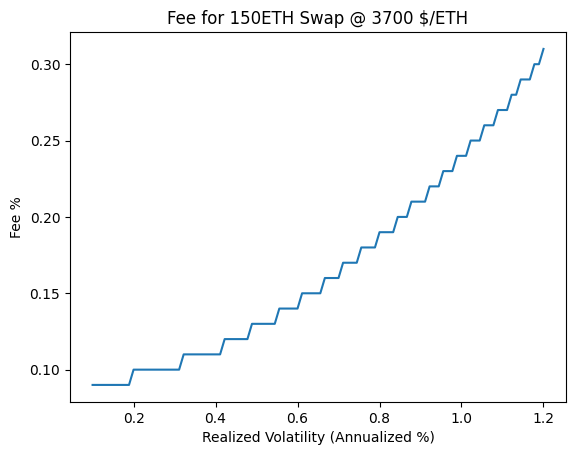

In [417]:
volatility = np.linspace(0.1, 1.2, 100)
volume = 150
fees = [calculateFeeBips(volume, int(v * 2**NUM_FRAC_BITS), ETH_PRICE_FIXED) / 100 for v in volatility]
plt.plot(volatility, fees)

# Add labels and title
plt.xlabel('Realized Volatility (Annualized %)')
plt.ylabel('Fee %')
plt.title('Fee for 150ETH Swap @ {} $/ETH'.format(ETH_PRICE))

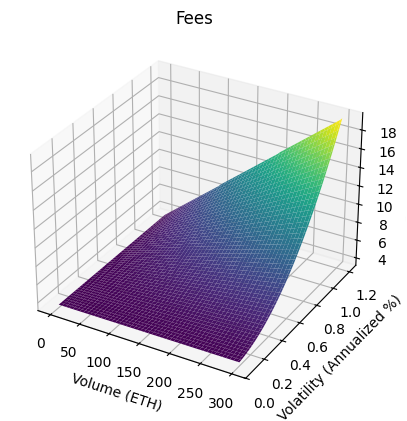

In [409]:
# Volatility and trade volume points
volatility = np.linspace(0.08, 1.2, 100) 
volume = np.linspace(0, 300, 100) # Volumes from 1 to 301

# Generate meshgrid for 3D plot
vol, volat = np.meshgrid(volume, volatility)

# Calculate fees for the meshgrid
fees = np.array([calculateFee(int(v), int(volat_val*2**NUM_FRAC_BITS)) * 2**-NUM_FRAC_BITS for v, volat_val in zip(np.ravel(vol), np.ravel(volat))])
fees = fees.reshape(vol.shape) # * 2**-num_factional_bits

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(vol, volat, fees, cmap='viridis')

# Set labels and title
ax.set_xlabel('Volume (ETH)')
ax.set_ylabel('Volatility (Annualized %)')
ax.set_zlabel('Fee (USDC)')
ax.set_title('Fees (USDC)')

plt.show()

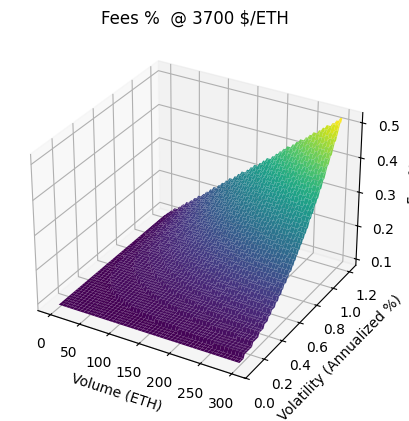

In [418]:
# Volatility and trade volume points
volatility = np.linspace(0.08, 1.2, 100) 
volume = np.linspace(0, 300, 100) # Volumes from 1 to 301

# Generate meshgrid for 3D plot
vol, volat = np.meshgrid(volume, volatility)

# Calculate fees for the meshgrid
fees = np.array([calculateFeeBips(int(v), int(volat_val*2**NUM_FRAC_BITS), ETH_PRICE_FIXED) /100 for v, volat_val in zip(np.ravel(vol), np.ravel(volat))])
fees = fees.reshape(vol.shape) # * 2**-num_factional_bits

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(vol, volat, fees, cmap='viridis')

# Set labels and title
ax.set_xlabel('Volume (ETH)')
ax.set_ylabel('Volatility (Annualized %)')
ax.set_zlabel('Fee %')
ax.set_title('Fees %  @ {} $/ETH'.format(ETH_PRICE))

plt.show()

## Testing using RV from smart contract

LONG_ETH_VOL: 855357604
109945665
0.0012312310372719218


Text(0.5, 1.0, 'Fee over time for 150ETH swap')

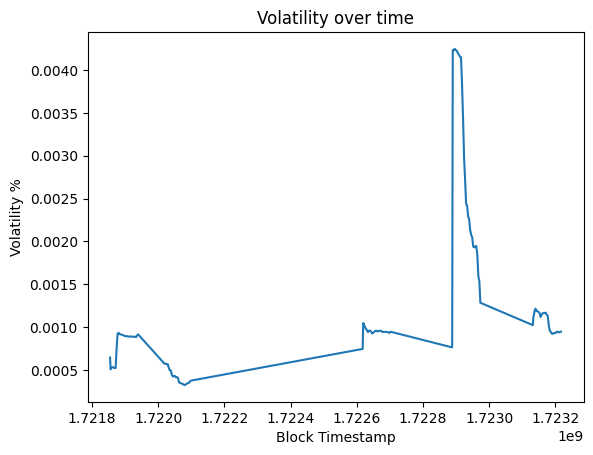

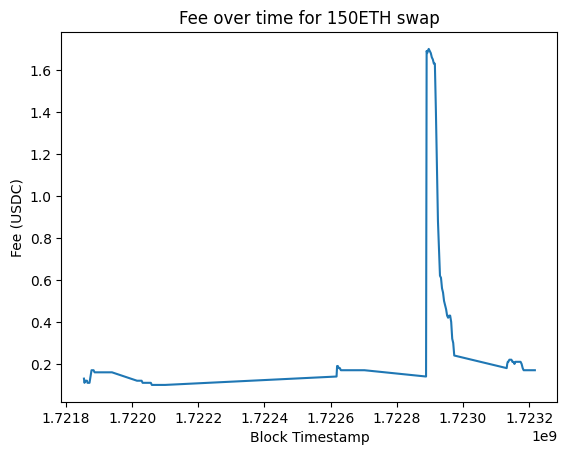

In [518]:
import json
import math 

FUDGE_FACTOR = 2

# Long-term daily ETH volatility, estimated from the data we've collected over the past few months.
# We are calculating volatiltiy differently than in the reference project.
# They calculate annualized volatility, we calculate per trade volatility.
# So the long-term volatility numbers are expected to be quite different.
# Our nu
LONG_ETH_VOL = 0.0007779432096665192  
LONG_ETH_VOL_FIXED = int(LONG_ETH_VOL * 2**NUM_FRAC_BITS)
print("LONG_ETH_VOL: {}".format(LONG_ETH_VOL_FIXED))


LN_1_0001 = int(math.log(1.0001) * 2**NUM_FRAC_BITS)
print(LN_1_0001)

# Load the JSON file
with open('/Users/severianosisneros/Desktop/rv_query.json', 'r') as file:
    data = json.load(file)

# Extract the relevant information
volatility_data = data["data"]["volatilityUpdateds"]

def calculateFeeFromRvOracle(entry, volume):
    new_rv = entry["newRv"]
    block_timestamp = entry["blockTimestamp"]
    
    # Convert newRv and blockTimestamp from strings to integers (optional)
    volatility_fixed = int(new_rv) # new_rv is a fixed-point number with 40 fractional bits
    volatility = volatility_fixed * 2**-NUM_FRAC_BITS
    block_timestamp = int(block_timestamp)

    # fee = calculateFee(volume, volatility_fixed) * 2 ** -NUM_FRAC_BITS
    fee = calculateFeeBips(volume, volatility_fixed, ETH_PRICE_FIXED) / 100
    
    return fee, block_timestamp, volatility

# Extract the relevant information
volatility_data = data["data"]["volatilityUpdateds"]

volume = 150
fees_timestamps_and_volatility = [calculateFeeFromRvOracle(entry, volume) for entry in volatility_data]

# Separate the fees and timestamps for plotting
fees = [fee for fee, timestamp, vol in fees_timestamps_and_volatility]
timestamps = [timestamp for fee, timestamp, vol in fees_timestamps_and_volatility]
vols = [vol for fee, timestamp, vol in fees_timestamps_and_volatility]

print(np.mean(vols))
plt.figure()
plt.plot(timestamps, vols)
# Add labels and title
plt.xlabel('Block Timestamp')
plt.ylabel('Volatility %')
plt.title('Volatility over time')

plt.figure()
plt.plot(timestamps, fees)
# Add labels and title
plt.xlabel('Block Timestamp')
plt.ylabel('Fee (USDC)')
plt.title('Fee over time for 150ETH swap')

In [506]:
math.sqrt(570027430964613.520948935779) * math.log(1.0001)

2387.4053561265378